### Import the necessary libraries

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [173]:
df = gpd.read_file('../data/processed/high_res.shp')

### Predict only using population density and HDI

In [174]:
#fit random forest model
X = df[['Pop_den', "HDI", "urbanicity"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

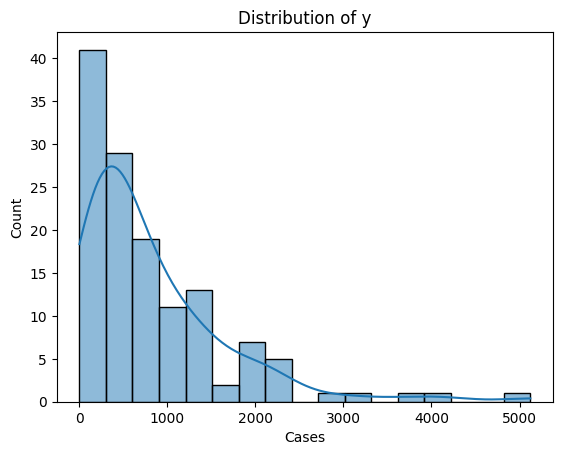

Skewness: 2.2377674169392368


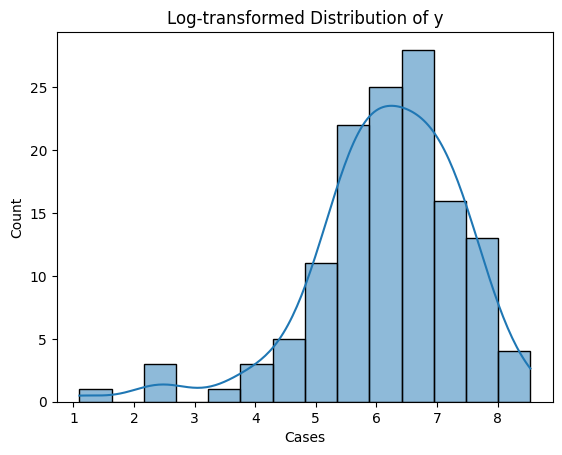

In [175]:
#plot the distribution of y to determine whether i need to log transform it
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of y
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log = np.log1p(y)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log, kde=True)
    plt.title("Log-transformed Distribution of y")
    plt.show()


In [176]:
#since log transforming doesnt rly help, can winzorise instead:
# Manual winsorization with pandas
lower = y.quantile(0.05)
upper = y.quantile(0.95)
y_winsorized = y.clip(lower=lower, upper=upper)


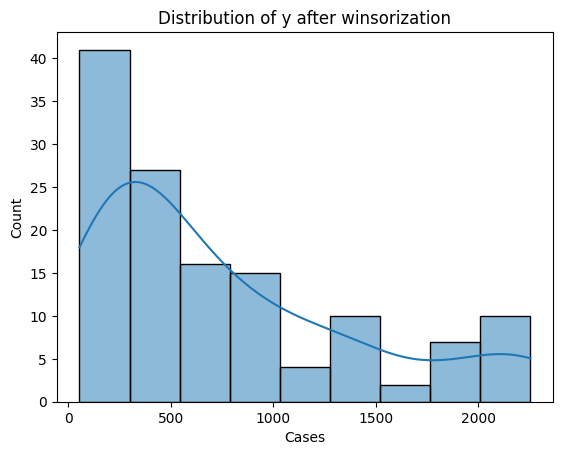

Skewness: 1.0312946432740635


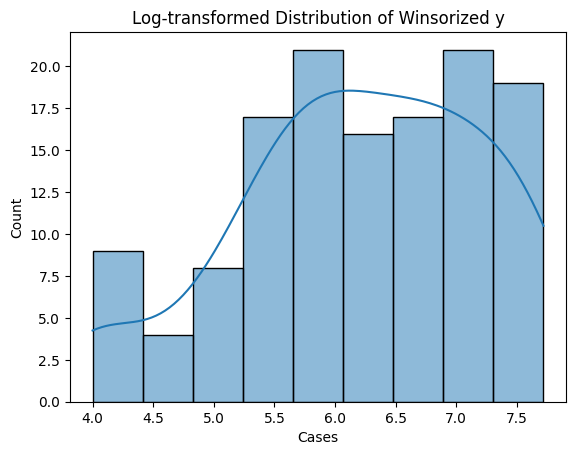

In [177]:
#check plot for y_winsorized
# Plot the distribution of y
sns.histplot(y_winsorized, kde=True)
plt.title("Distribution of y after winsorization")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y_winsorized.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log_w = np.log1p(y_winsorized)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log_w, kde=True)
    plt.title("Log-transformed Distribution of Winsorized y")
    plt.show()

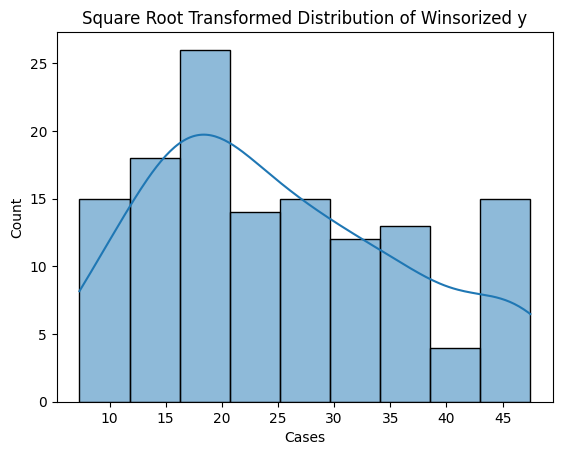

Skewness of sqrt-transformed y: 0.4317123919046788


In [178]:
#how abt square rooting:
y_sqrt = np.sqrt(y_winsorized)  # Square root transformation
sns.histplot(y_sqrt, kde=True)
plt.title("Square Root Transformed Distribution of Winsorized y")
plt.show()
print(f"Skewness of sqrt-transformed y: {y_sqrt.skew()}")


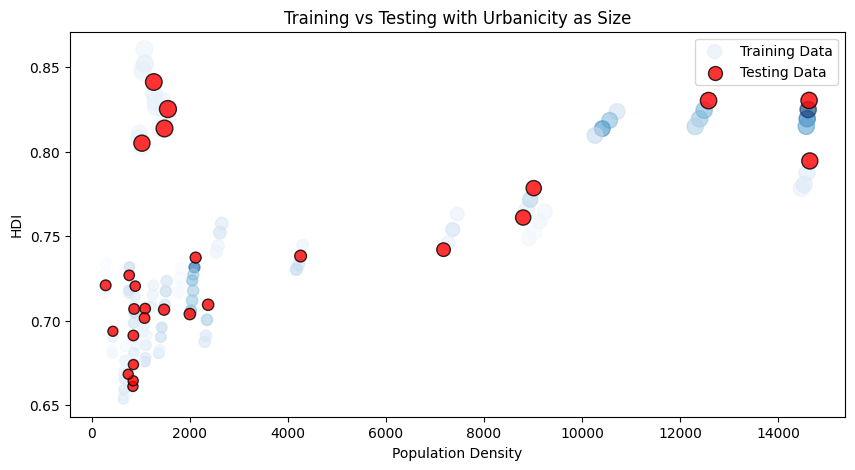

In [179]:
plt.figure(figsize=(10, 5))

# Training data
plt.scatter(X_train['Pop_den'], X_train['HDI'], 
            c=y_train, cmap='Blues', 
            s=50 + 100 * X_train['urbanicity'],  # marker size varies with urbanicity
            alpha=0.6, label='Training Data')

# Testing data
plt.scatter(X_test['Pop_den'], X_test['HDI'], 
            c='red', edgecolors='k', 
            s=50 + 100 * X_test['urbanicity'], 
            alpha=0.8, label='Testing Data')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.title('Training vs Testing with Urbanicity as Size')
plt.legend()
plt.show()


In [191]:
#fit random forest into train-test split using y_winsorized, y_log, y_sqrt, y_log_w
# Stratify based on 'Province'

# original y
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# after winsorisation
X_train, X_test, y_train_w, y_test_w, train_index, test_index = train_test_split(
    X, y_winsorized, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# after logging
X_train, X_test, y_train_l, y_test_l, train_index, test_index = train_test_split(
    X, y_log, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# after winsorisation and logging
X_train, X_test, y_train_lw, y_test_lw, train_index, test_index = train_test_split(
    X, y_log_w, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# after winsorisation and square-rooting
X_train, X_test, y_train_s, y_test_s, train_index, test_index = train_test_split(
    X, y_sqrt, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

In [181]:
# Create separate datasets for train - test data
df_pointer = df.copy()
df_pointer["split"] = "train"
df_pointer.loc[test_index, 'split'] = 'test'

# Save shapefiles directly
df_pointer[df_pointer["split"] == "train"].to_file('../data/processed/train.shp')
df_pointer[df_pointer["split"] == "test"].to_file('../data/processed/test.shp')


In [182]:
# Define your RandomForest model
rf = RandomForestRegressor(random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
}

def run_grid_search(X, y, cv_folds):
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=cv_folds,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X, y)
    return pd.DataFrame(grid_search.cv_results_)

cv_10_results = run_grid_search(X_train, y_train, 10)
cv_10_results_w = run_grid_search(X_train, y_train_w, 10)
cv_10_results_l = run_grid_search(X_train, y_train_l, 10)
cv_10_results_s = run_grid_search(X_train, y_train_s, 10)
cv_10_results_lw = run_grid_search(X_train, y_train_lw,10)


In [183]:
best_n = lambda results: results.loc[results['mean_test_score'].idxmax(), 'param_n_estimators']

print(f"Optimal n_estimators for 10-fold CV: {best_n(cv_10_results)}")
print(f"Optimal n_estimators for 10-fold CV with y_winsorized: {best_n(cv_10_results_w)}")
print(f"Optimal n_estimators for 10-fold CV with y_log: {best_n(cv_10_results_l)}")
print(f"Optimal n_estimators for 10-fold CV with y_sqrt: {best_n(cv_10_results_s)}")
print(f"Optimal n_estimators for 10-fold CV with y_logw: {best_n(cv_10_results_lw)}")


Optimal n_estimators for 10-fold CV: 500
Optimal n_estimators for 10-fold CV with y_winsorized: 300
Optimal n_estimators for 10-fold CV with y_log: 1000
Optimal n_estimators for 10-fold CV with y_sqrt: 500
Optimal n_estimators for 10-fold CV with y_logw: 500


In [192]:
#calculate MAE, RMSE, rhat for all those and choose the one w lowest RMSE and highest Rhat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

# Original y
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append({
    'version': 'original',
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
})

# Winsorized y
rf_w = RandomForestRegressor(n_estimators=300, random_state=42)
rf_w.fit(X_train, y_train_w)
y_pred_w = rf_w.predict(X_test)
results.append({
    'version': 'winsorized',
    'MAE': mean_absolute_error(y_test, y_pred_w),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_w)),
    'R2': r2_score(y_test, y_pred_w)
})

# Log transformed y
rf_l = RandomForestRegressor(n_estimators=500, random_state=42)
rf_l.fit(X_train, y_train_l)
y_pred_l = rf_l.predict(X_test)
# Inverse transform log1p: expm1
y_pred_l_inv = np.expm1(y_pred_l)
results.append({
    'version': 'log',
    'MAE': mean_absolute_error(y_test, y_pred_l_inv),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_l_inv)),
    'R2': r2_score(y_test, y_pred_l_inv)
})

# Square root winsorised transformed y
rf_s = RandomForestRegressor(n_estimators=500, random_state=42)
rf_s.fit(X_train, y_train_s)
y_pred_s = rf_s.predict(X_test)
# Inverse transform sqrt: square the predictions
y_pred_s_inv = y_pred_s ** 2
results.append({
    'version': 'sqrt winsorised',
    'MAE': mean_absolute_error(y_test, y_pred_s_inv),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_s_inv)),
    'R2': r2_score(y_test, y_pred_s_inv)
})

# Log transformed, winsorised y
rf_lw = RandomForestRegressor(n_estimators=500, random_state=42)
rf_lw.fit(X_train, y_train_lw)
y_pred_lw = rf_lw.predict(X_test)
# Inverse transform log1p: expm1
y_pred_lw_inv = np.expm1(y_pred_lw)
results.append({
    'version': 'log winsorised',
    'MAE': mean_absolute_error(y_test, y_pred_lw_inv),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lw_inv)),
    'R2': r2_score(y_test, y_pred_lw_inv)
})

# Turn results into a DataFrame and find the best version
results_df = pd.DataFrame(results)
best_version = results_df.sort_values(by=['RMSE', 'R2'], ascending=[True, False]).iloc[0]

print("All Results:\n", results_df)
print("\nBest version:\n", best_version)

All Results:
            version         MAE        RMSE        R2
0         original  647.148889  973.684981 -1.711592
1       winsorized  421.878599  539.711722  0.166873
2              log  494.980325  695.961174 -0.385343
3  sqrt winsorised  416.809123  538.708709  0.169967
4   log winsorised  401.884805  544.648710  0.151562

Best version:
 version    sqrt winsorised
MAE             416.809123
RMSE            538.708709
R2                0.169967
Name: 3, dtype: object


C:\Users\jessi\AppData\Local\Temp\ipykernel_9508\956864369.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color="blue")


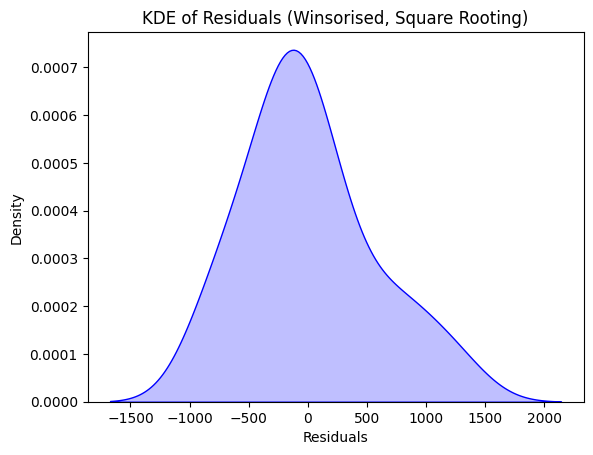

In [185]:
#plot the distribution of errors
# Calculate residuals (difference between observed and predicted values)
residuals = y_test - y_pred_s_inv

# Plot KDE of residuals
sns.kdeplot(residuals, shade=True, color="blue")
plt.title('KDE of Residuals (Winsorised, Square Rooting)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [186]:
# Add the predictions of y_sqrt winsorized to the test set (preserving indices)
X_test['Predicted_Cases'] = y_pred_s_inv

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

          District  Year  Area_sq_km     HDI    Province  Cases  Population  \
0          BANDUNG  2020     1767.96  0.7239  Jawa Barat   2295     3623790   
1          BANDUNG  2021     1767.96  0.7273  Jawa Barat   2002     3665655   
2          BANDUNG  2022     1767.96  0.7316  Jawa Barat   4191     3707523   
3          BANDUNG  2023     1767.96  0.7374  Jawa Barat   1005     3749391   
4    BANDUNG BARAT  2020     1305.77  0.6808  Jawa Barat    966     1788336   
..             ...   ...         ...     ...         ...    ...         ...   
127       SUMEDANG  2023     1518.33  0.7318  Jawa Barat   1308     1167785   
128    TASIKMALAYA  2020     2551.19  0.6567  Jawa Barat    179     1865203   
129    TASIKMALAYA  2021     2551.19  0.6590  Jawa Barat     47     1882945   
130    TASIKMALAYA  2022     2551.19  0.6684  Jawa Barat    319     1900688   
131    TASIKMALAYA  2023     2551.19  0.6776  Jawa Barat     88     1918433   

         Pop_den  urbanicity    hdi_qt  popden_qt  

In [187]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf.csv")

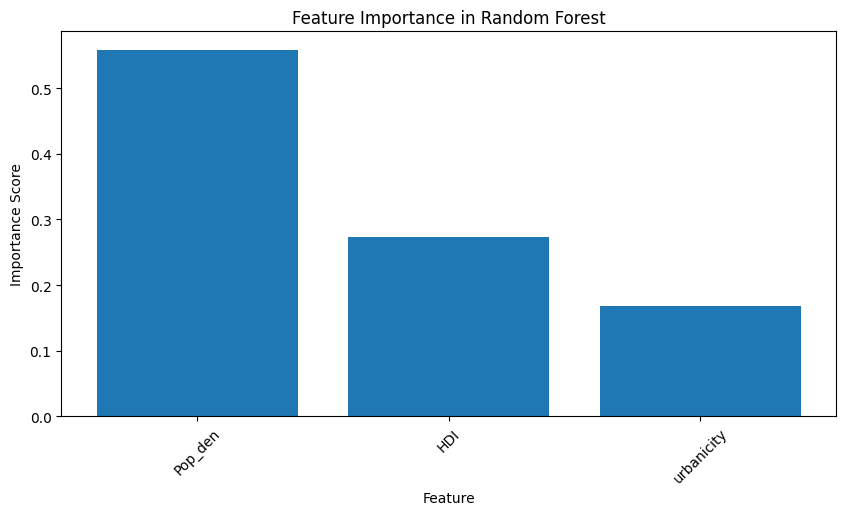

In [188]:
# Get feature importance
importances = rf_s.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [189]:
# Save the model
with open("../model_weights/rf/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)